In [365]:
import scipy.stats
from scipy.stats import binned_statistic as bs
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression as lr 
from sklearn.metrics import auc
import pandas as pd
import numpy as np
import os

FILE_PATH = os.path.join("datasets", "ps2")

# Function to load in csv file data
def load_file_data(file_name, file_path=FILE_PATH):
    os.makedirs(file_path, exist_ok=True)
    csv_path = os.path.join(file_path, file_name)
    return pd.read_csv(csv_path)

In [366]:
import random

data = load_file_data("ps2_public.csv")
data.info()
# Use existing proportion of True/False of family history to fill in missing values. True was 1.41% originally
for i, value in enumerate(data['family_history']):
    if(isinstance(value, float)):
        random_float = random.uniform(0.0, 100.0)
        if random_float <= 1.41:
            data["family_history"][i] = True
        else:
            data["family_history"][i] = False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       7500 non-null   int64  
 1   age             7500 non-null   int64  
 2   blood_pressure  7500 non-null   float64
 3   gender          7500 non-null   object 
 4   blood_test      7500 non-null   object 
 5   family_history  4893 non-null   object 
 6   TestA           7500 non-null   float64
 7   TestB           7500 non-null   float64
 8   GeneC           7500 non-null   object 
 9   GeneD           7500 non-null   int64  
 10  GeneE           7500 non-null   int64  
 11  GeneF           7500 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 703.2+ KB


<ipython-input-366-a19773889429>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["family_history"][i] = False
<ipython-input-366-a19773889429>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["family_history"][i] = True


In [367]:
# Observe treatment proportion is uneven
data['treatment'].value_counts()

-0.0005895136580696128

In [368]:
# Since all categorical data is binary, assign values of 0 and 1 to easily make them numerical

for i, value in enumerate(data['gender']):
    if value == "female":
        data["gender"][i] = 0
    elif value == "non-female":
        data["gender"][i] = 1
        
for i, value in enumerate(data['blood_test']):
    if value == "negative":
        data["blood_test"][i] = 0
    elif value == "positive":
        data["blood_test"][i] = 1
        
for i, value in enumerate(data['family_history']):
    if not value:
        data["family_history"][i] = 0
    else:
        data["family_history"][i] = 1

for i, value in enumerate(data['GeneC']):
    if value == "not active":
        data["GeneC"][i] = 0
    elif value == "active":
        data["GeneC"][i] = 1

<ipython-input-368-e7ce6771443f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gender"][i] = 1
<ipython-input-368-e7ce6771443f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gender"][i] = 0
<ipython-input-368-e7ce6771443f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["blood_test"][i] = 0
<ipython-input-368-e7ce6771443f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [369]:
# Remove outliers and values that do not make sense
data.drop(data[(data.blood_pressure < 0)].index , inplace=True)
data.drop(data[(data.TestA > 17) | (data.TestA < -8)].index , inplace=True)

In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7468 entries, 0 to 7499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       7468 non-null   int64  
 1   age             7468 non-null   int64  
 2   blood_pressure  7468 non-null   float64
 3   gender          7468 non-null   object 
 4   blood_test      7468 non-null   object 
 5   family_history  7468 non-null   object 
 6   TestA           7468 non-null   float64
 7   TestB           7468 non-null   float64
 8   GeneC           7468 non-null   object 
 9   GeneD           7468 non-null   int64  
 10  GeneE           7468 non-null   int64  
 11  GeneF           7468 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 758.5+ KB


In [371]:
# Change datatypes to int in order to compare with VIF
data = data.astype({'gender': 'int64', 'blood_test': 'int64', 'family_history': 'int64', 'GeneC': 'int64'})

In [372]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# When checking VIF, we can see age is highly correlated with blood pressure
# After analysis with both features, it was determined age was not needed in regression analysis
vif = pd.DataFrame(columns=['feature','score'])
features = ['age','blood_pressure', 'gender', 'blood_test', 'family_history','TestA', 'TestB', 'GeneC', 'GeneD', 'GeneE', 'GeneF']
vif["feature"] = features
vif["score"] = [variance_inflation_factor(data[features].values, i) for i in range(len(features))]
vif

,feature,score
0,age,81.024636
1,blood_pressure,56.080448
2,gender,1.611974
3,blood_test,1.095291
4,family_history,1.017518
5,TestA,5.029587
6,TestB,1.001624
7,GeneC,1.817834
8,GeneD,2.216364
9,GeneE,2.223616


In [373]:
data = data.drop(["age"], axis=1)

array([[<AxesSubplot:title={'center':'treatment'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>,
        <AxesSubplot:title={'center':'gender'}>],
       [<AxesSubplot:title={'center':'blood_test'}>,
        <AxesSubplot:title={'center':'family_history'}>,
        <AxesSubplot:title={'center':'TestA'}>],
       [<AxesSubplot:title={'center':'TestB'}>,
        <AxesSubplot:title={'center':'GeneC'}>,
        <AxesSubplot:title={'center':'GeneD'}>],
       [<AxesSubplot:title={'center':'GeneE'}>,
        <AxesSubplot:title={'center':'GeneF'}>, <AxesSubplot:>]],
      dtype=object)

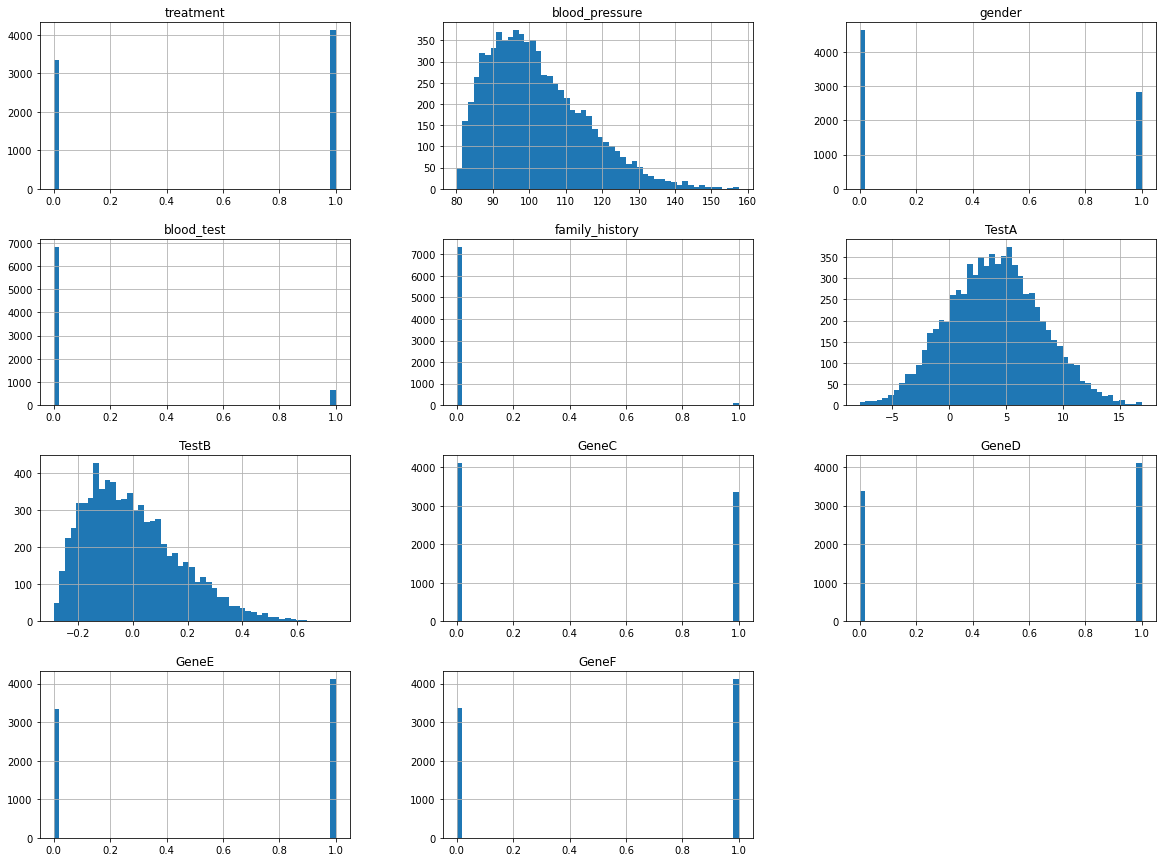

In [374]:
# An initial look at histograms of the numerical data/a breakdown of the binary
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

Text(0, 0.5, 'Frequency of Treatment')

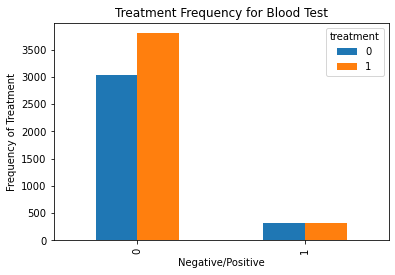

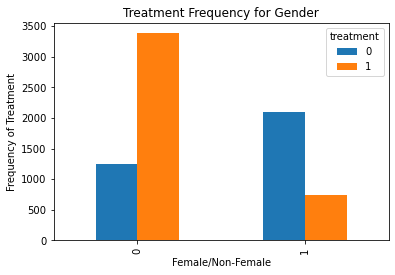

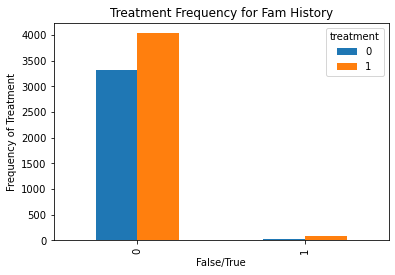

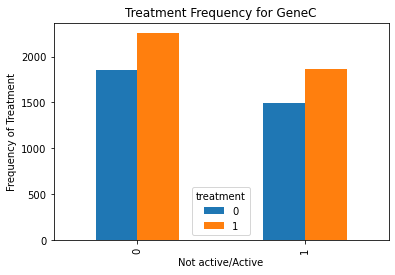

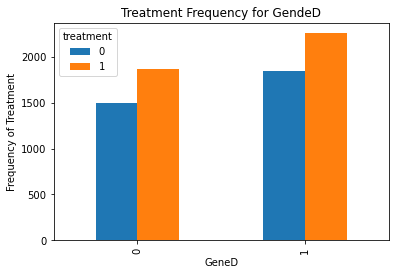

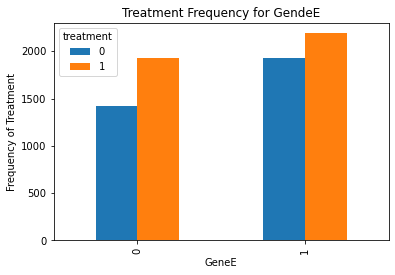

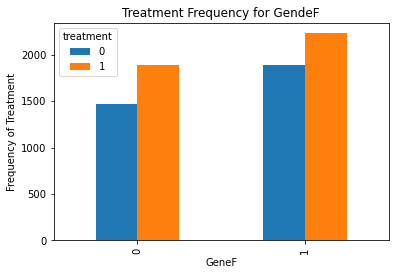

In [375]:
%matplotlib inline
# Bar graphs depicting binary variables and their relation to treatment frequency
# Gender and blood test initially appear to be strong predictors of treatment

pd.crosstab(data.blood_test,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for Blood Test')
plt.xlabel('Negative/Positive')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.gender,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for Gender')
plt.xlabel('Female/Non-Female')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.family_history,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for Fam History')
plt.xlabel('False/True')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.GeneC,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for GeneC')
plt.xlabel('Not active/Active')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.GeneD,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for GendeD')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.GeneE,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for GendeE')
plt.ylabel('Frequency of Treatment')

pd.crosstab(data.GeneF,data.treatment).plot(kind='bar')
plt.title('Treatment Frequency for GendeF')
plt.ylabel('Frequency of Treatment')

In [376]:
# Separating the dependent variable from the features to observe model accuracy later
treatment_labels = data["treatment"].copy()
data = data.drop("treatment", axis=1)

In [377]:
# Employing the Synthetic Minority Oversampling Technique to combat there being more individuals who received treatment in our sample than didn't

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data, treatment_labels, test_size=0.2, random_state=0)

# After splitting data and fitting the model, our data will be balanced
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['treatment'])

In [378]:
# Using recursive feature elimination to determine which features are most important in our model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
rfe = RFE(log, 6)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True  True False False  True False]
[5 1 1 1 1 1 2 4 1 3]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [379]:
# After a few iterations we will try these 8 features 
cols=['gender', 'family_history', 'TestB', 'GeneC', 'GeneE', 'TestA', 'GeneD', 'blood_test'] 
X=os_data_X[cols]
y=os_data_y['treatment']

In [380]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.585490
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.155      
Dependent Variable: treatment        AIC:              7791.3063  
Date:               2021-02-23 06:44 BIC:              7845.7132  
No. Observations:   6640             Log-Likelihood:   -3887.7    
Df Model:           7                LL-Null:          -4602.5    
Df Residuals:       6632             LLR p-value:      1.4541e-304
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender            -1.7975   0.0576 -31.2170 0.0000 -1.9103 -1.6846
family_history     1.6906   0.2781   6.0792 0.0000  1

In [381]:
# The chart above shows blood_test had a p value above .05 so it was removed
# After other experimention, GeneD was also removed as it had no additional positive effect later on
cols=['gender', 'family_history', 'TestB', 'GeneC', 'GeneE', 'TestA'] 
X=os_data_X[cols]
y=os_data_y['treatment']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.594707
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.142      
Dependent Variable: treatment        AIC:              7909.7147  
Date:               2021-02-23 06:44 BIC:              7950.5199  
No. Observations:   6640             Log-Likelihood:   -3948.9    
Df Model:           5                LL-Null:          -4602.5    
Df Residuals:       6634             LLR p-value:      1.6911e-280
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender            -1.6868   0.0563 -29.9346 0.0000 -1.7972 -1.5763
family_history     1.7430   0.2763   6.3094 0.0000  1

In [382]:
# We can now fit our remaining features in our logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression()

In [383]:
print("Gender (male):", log.coef_[0][0],
      "\nFamily History (positive):", log.coef_[0][1],
      "\nTestA:", log.coef_[0][5],
      "\nTestB:", log.coef_[0][2],
      "\nGeneC (active):", log.coef_[0][3],
      "\nGeneE (present):", log.coef_[0][4],
      "\nInt:", log.intercept_)

Gender (male): -2.160805448075065 
Family History (positive): 1.2907660678958892 
TestA: -0.11972000967143934 
TestB: -1.1174219596769428 
GeneC (active): 0.12504455636708606 
GeneE (present): -0.2002080042236357 
Int: [1.36898851]


In [384]:
y_pred = log.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(log.score(X_test, y_test)))

Accuracy of logistic regression: 0.73


In [385]:
# Create a confusion matrix showing true positives, false positives, true negatives, and false negatives for the test set clockwise
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[443 228]
 [128 529]]


In [386]:
# Create a report based on the regression for key statistics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       671
           1       0.70      0.81      0.75       657

    accuracy                           0.73      1328
   macro avg       0.74      0.73      0.73      1328
weighted avg       0.74      0.73      0.73      1328



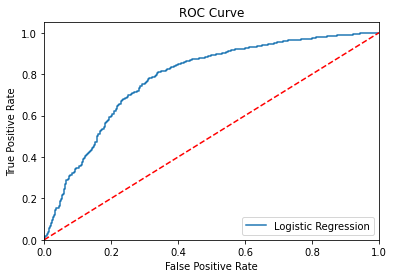

ROC-AUC:  0.7815205728971729


In [387]:
# Make an ROC Curve in order to observe the ROC-AUC score, giving more insight into the performance of the model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, log.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
print('ROC-AUC: ',auc(fpr, tpr))